# Анализ сервиса аренды самокатов

**Примечание** 

Проект является тренировочным и выполнен в ходе обучения

Сервис аренды самокатов GoFast передал нам данные о некоторых пользователях из разных городов и их поездках. Нам необходимо подготовить данные к работе, а затем провести исследовательский и статистический анализ данных. Наша конечная задача - проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Вся работа пройдёт в 6 этапов:
1. Загрузка и ознакомление с данными
2. Предобработка
3. Исследовательский анализ и визуализация отдельных параметров
4. Объединение данных из разных датасетов
5. Подсчёт выручки, которую принёс сервису каждый пользователь
6. Проверка трёх нулевых гипотез

В распоряжении мы имеем 3 датасета
- **users_go**, содержащий информацию о пользователях, где:
 - `user_id` - Уникальный идентификатор пользователя
 - `name` - Имя пользователя
 - `age` - Возраст пользователя
 - `city` - Город проживания пользователя
 - `subscription_type` - Тип подписки, free или ultra


- **rides_go**, содержащий информацию о поездках, где:
 - `user_id` - Идентификатор пользователя, совершившего поездку
 - `distance` - Дистанция поездки в метрах	
 - `duration`	- Продолжительность поездки в минутах
 - `date` - Дата совершения поездки


- **subscriptions_go**, содержащий информацию о разных типах подписки, где:
 - `subscription_type` - Тип подписки, free или ultra
 - `minute_price` - Стоимость минуты поездки
 - `start_ride_price` - Стоимость старта поездки
 - `subscription_fee` - Помесячная стоимость подписки

In [1]:
import pandas as pd # Импорт необходимых библиотек
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st 

## Этап 1. Загрузка данных

In [2]:
def dataset_info(ds, info=True):
    display(ds.head())
    print(f'Количество дубликатов: {ds.duplicated().sum()}')
    print(f'Длина датасета: {len(ds)}')
    if info: ds.info()

In [3]:
users = pd.read_csv('datasets/users_go.csv') # Датасет с информацией о пользователях
dataset_info(users)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


Количество дубликатов: 31
Длина датасета: 1565
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
rides = pd.read_csv('datasets/rides_go.csv') # Датасет с информацией о поездках
dataset_info(rides)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Количество дубликатов: 0
Длина датасета: 18068
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [5]:
subs = pd.read_csv('datasets/subscriptions_go.csv') # Датасет с информацией о типах подписки
dataset_info(subs)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Количество дубликатов: 0
Длина датасета: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Пропусков в данных нет, отлично. Среди пользователей есть дубликаты. И столбец date библиотека pandas посчитала за строку. Исправим всё это на этапе предобработки.

## Этап 2. Предобработка данных

Начнём с даты, сохраним её в соответствующем типе datetime, а заодно проверим какие годы затрагивают записи.

In [6]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d', errors='coerce') # Перевод столбца date в соответствующий формат
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [7]:
rides['date'].dt.year.unique() # Уникальные значения года 

array([2021], dtype=int64)

Тип поменялся успешно, ошибок не прибавилось. Год записей только один - 2021.

Далее воспользуемся новым форматом и выведем месяц в отдельный столбец для удобного доступа

In [8]:
rides['month'] = rides['date'].dt.month # Создание нового столбца с номером месяца
rides.head(5)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


И, наконец, удалим дубликаты датасета users, проверим не попадаются-ли пользователи с одинаковым id, и ещё раз убедимся, что пропусков в данных нет.

In [9]:
users = users.drop_duplicates() # Сброс явных дубликатов
users.duplicated().sum()

0

In [10]:
(users['user_id'].value_counts()>1).sum() # Подсчёт id, встречающихся более 1 раза

0

Все значения user_id встречаются только по одному разу. Дубликатов нет.

In [11]:
for i in [users, rides, subs]: # Подсчёт количества пропусков в датасетах
    print(i.isna().sum())
    print()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64



Пропусков тоже нет. 

Итого мы преобразовали формат даты, вывели месяц в отдельный столбец, сбросили полные дубликаты пользователей, и убедились что в данных больше нет дубликатов или пропусков. На этом предобработка заканчивается, данные в хорошем состоянии.

## Этап 3. Исследовательский анализ данных

На этом этапе мы опишем и визуализируем отдельные параметры

In [12]:
def values_present(ds, title, label, bins=12): # Функция для быстрой презентации данных 
    ds.plot(kind='hist', bins=bins, title=title, grid=True) # Постройка графика
    plt.xlabel(label) # Подпись значений
    display(ds.describe()) # Общее описание данных

### Частота встречаемости городов

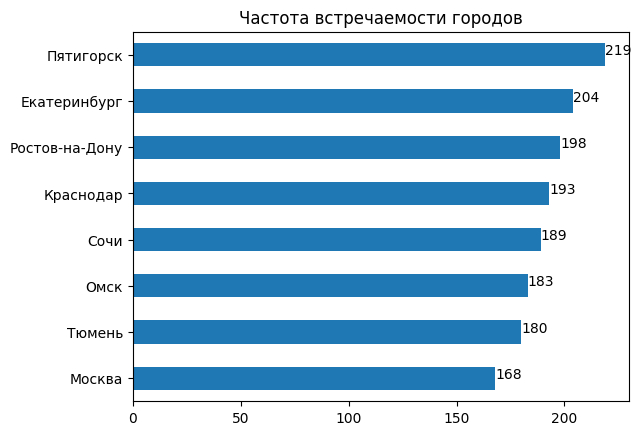

In [13]:
users['city'].value_counts().sort_values().plot(kind = 'barh', title='Частота встречаемости городов');
for i, j in enumerate(users['city'].value_counts().sort_values()): # Расставление значений на графике
    plt.text(j, i, str(j))

Выборки распределены сравнительно равномерно. Больше всего выборка пользователей из Пятигорска, а меньше всего, к удивлению, из Москвы.

### Соотношение пользователей с подпиской и без

free     835
ultra    699
Name: subscription_type, dtype: int64

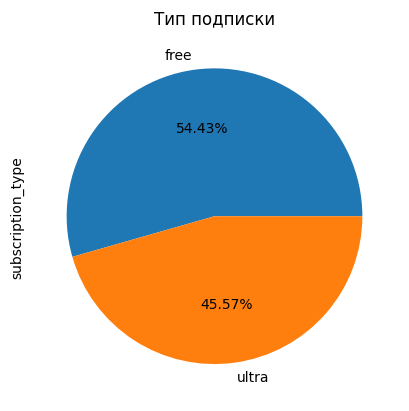

In [14]:
users['subscription_type'].value_counts().plot(kind='pie', autopct='%1.2f%%', labels=users['subscription_type'].value_counts().index);
plt.title('Тип подписки');
users['subscription_type'].value_counts()

Пользователей с бесплатной подпиской немного больше.

### Возраст пользователей

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

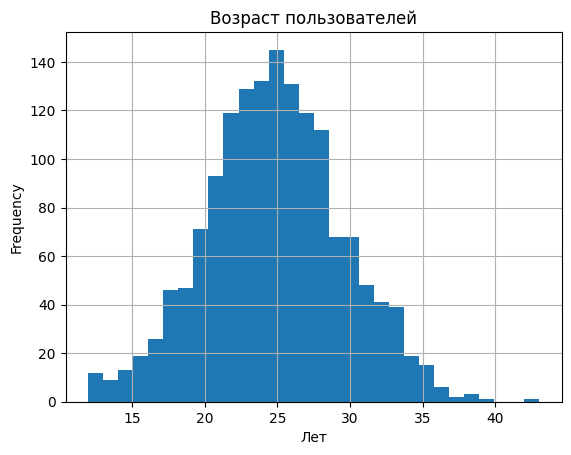

In [15]:
values_present(users['age'], 'Возраст пользователей', 'Лет', 30)

25 лет - золотая середина, однако встречаются и пользователи младше 15, и старше 40 лет.

### Расстояние поездок

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

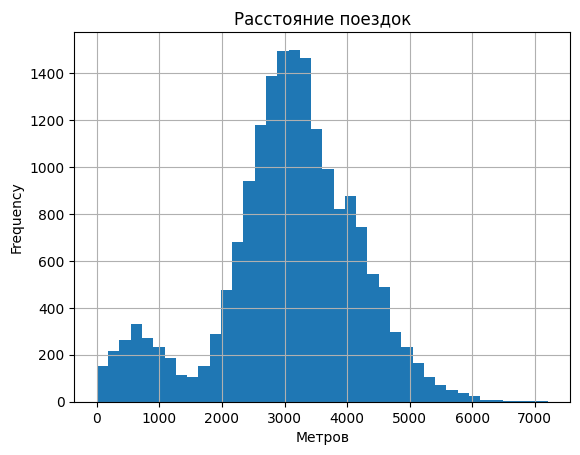

In [16]:
values_present(rides['distance'], 'Расстояние поездок', 'Метров', 40)

Небольшой пик около 700 метров. Это могут быть поездки до ближайшей остановки общественного транспорта или станции метро. Чаще всего пользователи одолевают 3-3.5 километра за одну поездку.

### Продолжительность поездок

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

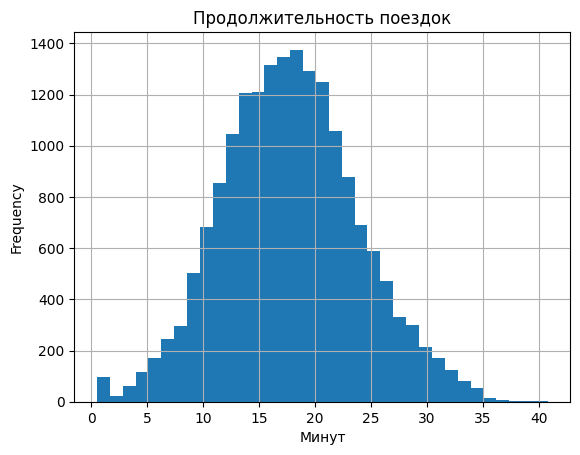

In [17]:
values_present(rides['duration'], 'Продолжительность поездок', 'Минут', 35) # Гистограмма длительности поездок, в минутах

Подозрительный пик возле нуля, взглянем на него поближе.

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


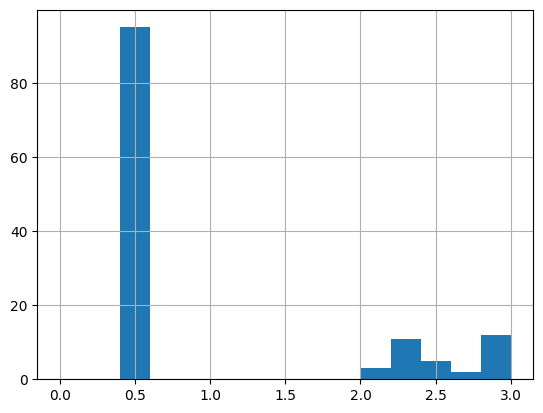

In [18]:
rides['duration'].hist(range=(0, 3), bins=15); # Гистограмма участка значений от 0 до 3
rides[rides['duration'] < 1.5] # Все записи, где длительность меньше 1.5

95 записей с одинаковым значением продолжительности, равным 0.5. Это может быть как стандартное значение, назначаемое в случае ошибки, так и особенность заполнения данных, например связанная с проведением акций. Записей не настолько много, чтобы они испортили результат исследований, поэтому пока оставим их нетронутыми, но было-бы неплохо уточнить у сотрудников, ответственных за систему регистрации данных, с чем может быть связан этот всплеск.

Чаще всего поездка длится 10-25 минут. 

## Этап 4. Объединение данных

### Формирование общего датасета

Для начала объединим все данные в одну таблицу.

In [19]:
ds_full = rides.merge(users, on='user_id') # Объединение датасетов с поездками и пользователями, по user_id
ds_full = ds_full.merge(subs, on='subscription_type') # Объединение общего датасета с данными о типах подписки
dataset_info(ds_full)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Количество дубликатов: 0
Длина датасета: 18068
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1

### Создание раздельных таблиц для типов подписки

Теперь разделим все данные на две категории - пользователи с подпиской и пользователи без подписки.

In [20]:
ds_free = ds_full[ds_full['subscription_type'] == 'free'] # Создание датасета только с пользователями без подписки
dataset_info(ds_free, False)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


Количество дубликатов: 0
Длина датасета: 11568


In [21]:
ds_ultra = ds_full[ds_full['subscription_type'] == 'ultra'] # Создаиние датасета только с пользователями с подпиской
dataset_info(ds_ultra, False)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Количество дубликатов: 0
Длина датасета: 6500


### Визуализация расстояния и времени поездок для разных типов подписок

In [22]:
def min_mean_max(text1, ds1): # Функция для быстрого описания данных. p.s. я знаю о describe(), но там слишком много ненужной информации
    print(f'{text1} Минимальное: {ds1.min().round(1)}, Среднее: {ds1.mean().round(1)}, Максимальное: {ds1.max().round(1)}')

Последовательно визуализируем и то и другое

Дистанция поездок пользователей без подписки. Минимальное: 0.9, Среднее: 3045.5, Максимальное: 7211.0
Дистанция поездок пользователей с подпиской. Минимальное: 244.2, Среднее: 3115.4, Максимальное: 5699.8


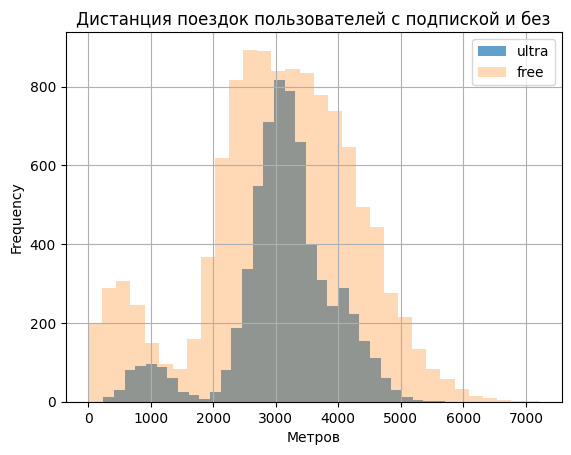

In [23]:
ds_free['distance'].plot(ax=ds_ultra['distance'].plot(kind = 'hist', grid=True, legend=True, label='ultra', alpha=0.7, bins=32), kind = 'hist', grid=True, legend=True, label='free', alpha=0.3, bins=32); 
plt.title('Дистанция поездок пользователей с подпиской и без')
plt.xlabel('Метров')
# Совместная гистограмма дистанции поездок для пользователей с подпиской и без, метров
min_mean_max('Дистанция поездок пользователей без подписки.', ds_free['distance'])
min_mean_max('Дистанция поездок пользователей с подпиской.', ds_ultra['distance'])

Данных о поездках пользователей без подписки в целом больше. При этом они чаще совершают короткие поездки менее километра, и из-за этого средняя дистанция пользователей без подписки меньше, чем у пользователей с подпиской. У обоих типов пользователей существует небольшой пик около 700-1000 метров. При этом самые часто встречающиеся значения дистанции у пользователей без подпискки распределены почти равномерно от ~2200 метров и до ~3500, а у пользователей с подпиской ярко выраженный пик на ~3000 метров. Можно сказать, что пользователи без подписки чаще ездят на разные дистанции.

Время поездок пользователей без подписки. Минимальное: 0.5, Среднее: 17.4, Максимальное: 34.9
Время поездок пользователей с подпиской. Минимальное: 3.8, Среднее: 18.5, Максимальное: 40.8


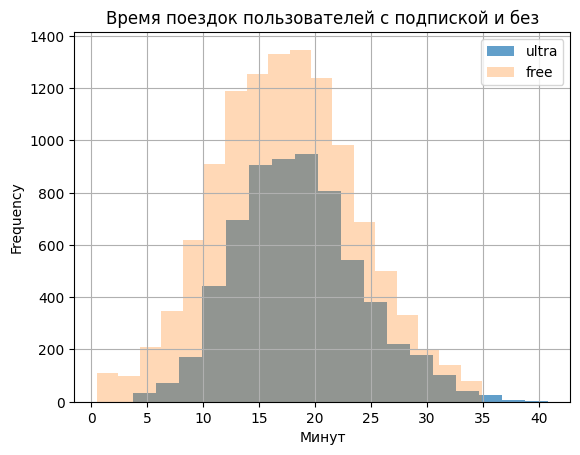

In [24]:
ds_free['duration'].plot(ax=ds_ultra['duration'].plot(kind = 'hist', grid=True, legend=True, label='ultra', alpha=0.7, bins=18), kind = 'hist', grid=True, legend=True, label='free', alpha=0.3, bins=18);
plt.title('Время поездок пользователей с подпиской и без')
plt.xlabel('Минут')
# Совместная гистограмма времени поездок для пользователей с подпиской и без, минут
min_mean_max('Время поездок пользователей без подписки.', ds_free['duration'])
min_mean_max('Время поездок пользователей с подпиской.', ds_ultra['duration'])

Точно так-же как и на предыдущем графике, данных о поездках пользоветелей без подписки больше. При этом пользователи с подпиской почти никогда не совершают поездки короче 4 минут, и в среднем их поездки длятся на 1 минуту больше.

## Этап 5. Подсчёт выручки

Теперь подсчитаем, сколько выручки каждый пользователь принёс сервису за разные месяцы. Для этого создадим сводную таблицу со всеми необходимыми данными и с их помощью проведём вычисления.

In [25]:
revenue_pivot = ds_full; revenue_pivot['count'] = 1 # Временный столбец для удобного подсчёта количества поездок
revenue_pivot['duration'] = np.ceil(revenue_pivot['duration']).astype('int')
revenue_pivot = revenue_pivot.pivot_table(index=['user_id', 'month'], values=['count', 'duration', 'distance'], aggfunc='sum').merge(ds_full.pivot_table(index=['user_id', 'month'], values=['minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type'], aggfunc='first'), on=['user_id', 'month']) # Объединение двух сводных таблиц, одна с суммой количества, дистанции и времени, другая с первым встреченным значением стоимости минуты, начала поездки и стоимости подписки. Все данные сгруппированы для каждого пользователя по месяцам
revenue_pivot['revenue'] = revenue_pivot['subscription_fee']+revenue_pivot['start_ride_price']*revenue_pivot['count']+revenue_pivot['minute_price']*revenue_pivot['duration'] # Подсчёт выручки по месяцам для каждого пользователя. Считается как (стоимость подписки + стоимость начала поездки*количество поездок + стоимость минуты*время поездок)
revenue_pivot.head(15)

count      distance  duration  minute_price  start_ride_price  \
user_id month                                                                  
1       1          2   7027.511294        42             6                 0   
        4          1    754.159807         7             6                 0   
        8          2   6723.470560        46             6                 0   
        10         2   5809.911100        32             6                 0   
        11         3   7003.499363        56             6                 0   
        12         2   6751.629942        28             6                 0   
2       3          3  10187.723006        63             6                 0   
        4          2   6164.381824        40             6                 0   
        6          1   3255.338202        14             6                 0   
        7          2   6780.722964        48             6                 0   
        8          1    923.007439         7             6                 0   
        10         1   2824.636598        19             6                 0   
        12         1   3828.248580        12             6                 0   
3       1          1   3061.777147        13             6                 0   
        2          2   5421.152016        39             6                 0   

               subscription_fee subscription_type  revenue  
user_id month                                               
1       1                   199             ultra      451  
        4                   199             ultra      241  
        8                   199             ultra      475  
        10                  199             ultra      391  
        11                  199             ultra      535  
        12                  199             ultra      367  
2       3                   199             ultra      577  
        4                   199             ultra      439  
        6                   199             ultra      283  
        7                   199             ultra      487  
        8                   199             ultra      241  
        10                  199             ultra      313  
        12                  199             ultra      271  
3       1                   199             ultra      277  
        2                   199             ultra      433

Выручка посчитана. Теперь у нас есть всё необходимое для проверки гипотез.

## Этап 6. Проверка гипотез

На этом этапе мы будем выдвигать разные нулевые гипотезы, а после отвергать их, или не отвергать, в пользу альтернативных.

In [26]:
alpha = .05 # Уровень статистической значимости 5%

In [27]:
def pvalue_check(ttest, arr1, arr2): # Функция для презентации результатов t-тестов
    print(f'pvalue:{ttest.pvalue}\nСреднее первой выборки: {arr1.mean().round(1)}')
    if type(arr2) == type(arr1): 
        print(f'Среднее второй выборки: {arr2.mean().round(1)}')
    else:
        print(f'Предполагаемое среднее: {arr2}')
    if ttest.pvalue<alpha:
        print('Нулевая гипотеза отвергается')
    else:
        print('Нулевая гипотеза не может быть опровергнута')

### Среднее время поездки

Нулевая гипотеза - Среднее время, затраченное на поездки пользователями с подпиской, равно среднему времени, затраченному на поездки пользователями без подписки.

Альтернативная гипотеза - Среднее время, затраченное на поездки пользователями с подпиской, больше, чем среднее время, затраченное на поездки пользователями без подписки.

In [28]:
pvalue_check(st.ttest_ind(ds_ultra['duration'], ds_free['duration'], equal_var=False, alternative='greater'), ds_ultra['duration'], ds_free['duration'])
# правосторонний ttest для независимых выборок, первая - пользователи с подпиской, вторая - пользователи без подписки.

pvalue:5.675781377128977e-37
Среднее первой выборки: 18.5
Среднее второй выборки: 17.4
Нулевая гипотеза отвергается


Наблюдаемое значение слишком далеко от ожидаемого. Есть основания полагать, что пользователи с подпиской тратят на поездки больше времени.

### Среднее расстояние одной поездки пользователей с подпиской

Нулевая гипотеза - Среднее расстояние, которое пользователи с подпиской проезжают за одну поездку равно 3130 метрам

Альтернативная гипотеза - Среднее расстояние, которое пользователи с подпиской проезжают за одну поездку больше, чем 3130 метров

In [29]:
pvalue_check(st.ttest_1samp(ds_ultra['distance'], 3130, alternative='greater'), ds_ultra['distance'], 3130) # правосторонний ttest для одиночной выборки с предполагаемым средним

pvalue:0.9195368847849785
Среднее первой выборки: 3115.4
Предполагаемое среднее: 3130
Нулевая гипотеза не может быть опровергнута


Вероятность случайному значению из выборки попасть в диапазон предполагаемого среднего слишком велика, чтобы отвергать гипотезу. Можно сказать, что среднее расстояние одной поездки пользователей с подпиской не превышает 3130 метров.

### Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки

Нулевая гипотеза - Средняя помесячная выручка от пользователей с подпиской равна средней помесячной выручке от пользователей без подписки.

Альтернативная гипотеза - Средняя помесячная выручка от пользователей с подпиской выше, чем средняя помесячная выручка от пользователей без подписки

In [30]:
pvalue_check(st.ttest_ind(revenue_pivot.loc[revenue_pivot['subscription_type'] == 'ultra', 'revenue'], revenue_pivot.loc[revenue_pivot['subscription_type'] == 'free', 'revenue'], equal_var=False, alternative='greater'), revenue_pivot.loc[revenue_pivot['subscription_type'] == 'ultra', 'revenue'], revenue_pivot.loc[revenue_pivot['subscription_type'] == 'free', 'revenue']) 
# независимый правосторонний ttest для помесячной выручки. Первая выборка - пользователи с подпиской, вторая - пользователи без подписки

pvalue:8.874140893976874e-40
Среднее первой выборки: 362.8
Среднее второй выборки: 328.6
Нулевая гипотеза отвергается


Если считать, что выборка репрезентативна - мы можем отвергнуть нулевую гипотезу в пользу альтернативной, и полагать что среднестатистический пользователь с подпиской за месяц приносит сервису б**о**льшую выручку, чем среднестатистический пользователь без подписки.

## Общий вывод

**Предобработка**

В рамках предобработки:
- Была приведена дата к соответствующему типу
- Дубликаты в записях о пользователях были удалены
- Была выполнена проверка на пропущенные значения

В целом, можно сказать, что данные в хорошем состоянии.

**Исследовательский анализ**

Была визуализирована информация о:
- Частоте встречаемости городов - Самая большая выборка из Пятигорска, самая маленькая - из Москвы
- Количестве пользователей с подпиской и без - Пользователей без подписки в выборке немного больше `54.5%:45.5%`
- Возрасте пользователей - Абсолютное большинство пользователей находятся в возрасте от 20 до 30 лет. А чаще всего встречается возраст 25 лет.
- Расстоянии поездок - Чаще всего поездки совершаются на ~3000 метров. При этом умеренно часто встречаются поездки менее 1500 метров.
- Продолжительности поездок - Чаще всего встречаются значения от 10 до 25 минут

В рамках группировки данных были раздельно визуализированы следующие показатели пользователей с подпиской и без:
- Дистанция поездок - Пользователи без подписки чаще ездят на короткие дистанции менее километра, чем пользователи с подпиской. При этом записей о поездках пользователей без подписки гораздо больше, чем о поездках пользователей с подпиской. Настолько, что в разницу между выборками в 5% это уже не укладывается. Видимо пользователи без подписки в целом совершают больше поездок.
- Время поездок - Точно так-же записей о пользователях без подписки больше, при этом оба пика находятся на приблизительно одинаковых значениях в 15-20 минут. 

Также были обнаружены и заменены медианой аномальные значения продолжительности поездок.

**Статистический анализ**

Были последовательно проверены 3 нулевые гипотезы:
1. Пользователи с подпиской и без подписки тратят на поездки одинаковое количество времени
 - Гипотеза была опровергнута, пользователи с подпиской тратят больше времени на поездки.
2. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метрам
 - Гипотезу не удалось опровергнуть
3. Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки
 - Гипотеза была опровергнута, выручка от пользователей с подпиской больше.

**Рекомендации заказчику**

- Определить причину возникновения дубликатов в данных о пользователях.
- Определить причину возникновения аномальных значений в данных о продолжительности поездок (95 записей со значением 0.5)
- Направить усилия на увеличение числа пользователей с подпиской. Результаты статистического анализа показали, что среднестатистический пользователь с подпиской в среднем в месяц приносит больше выручки, чем среднестатистический пользователь без подписки.